# Załadowanie danych

In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

/
Mounted at /content/gdrive
'Biwak miejsca.gmap'   data_for_train	       'Google Earth'   Passwords.kdbx
'Colab Notebooks'     'Forgotten places.gmap'  'My Drive'


In [2]:
!cp /mydrive/data_for_train/wydruk_3d.zip ./

In [3]:
!unzip ../wydruk_3d.zip -d content/
%cd content/

Archive:  ../wydruk_3d.zip
   creating: content/wydruk_3d/
  inflating: content/wydruk_3d/1a4e1cf7-8021-4963-b67a-da7ba93b2a78.jpg  
  inflating: content/wydruk_3d/1cda8713-2430-4f03-ae05-6ddafc9fb09a.jpg  
  inflating: content/wydruk_3d/207833bb-a893-4c94-9fe2-194ec217367d.jpg  
  inflating: content/wydruk_3d/2e9b7ff8-94d6-425d-8e0d-233fb72db50c.jpg  
  inflating: content/wydruk_3d/33fd4691-e875-4e3a-9942-8a85ad44b3c1.jpg  
  inflating: content/wydruk_3d/4148dfba-18a1-478d-95a7-5706e11aa809.jpg  
  inflating: content/wydruk_3d/7148ff34-e75e-4c49-bab6-455a038282b6.jpg  
  inflating: content/wydruk_3d/8597d258-7106-4e69-a4c0-c1fe703987be.jpg  
  inflating: content/wydruk_3d/b67ff026-dcba-4d53-95e1-60c04ecd8d53.jpg  
  inflating: content/wydruk_3d/c3715e41-4d2b-42a2-8998-ec17c38cc146.jpg  
  inflating: content/wydruk_3d/fde17f64-630e-4e4b-82c6-7d031b35c5d3.jpg  
/content


In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
%matplotlib inline
images_path_list = glob.glob("./wydruk_3d/*.jpg")

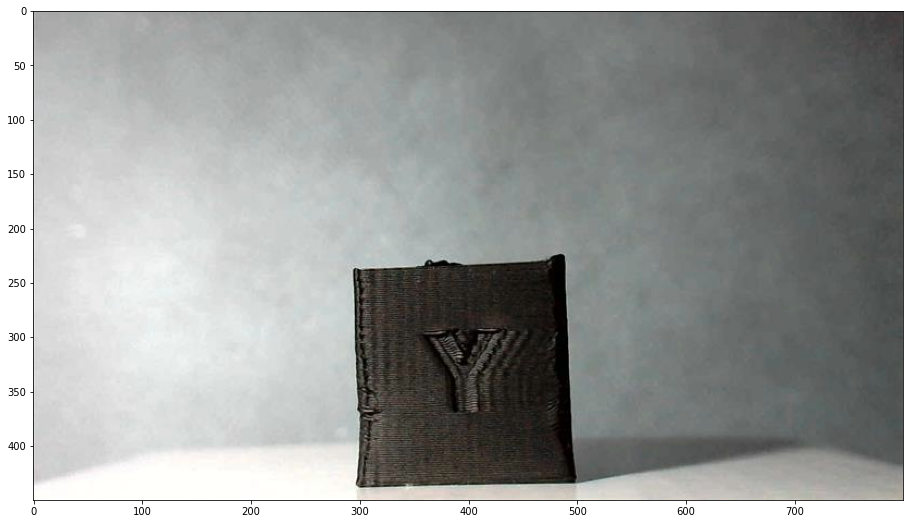

In [5]:
#image_path = random.choice(images_path_list)
main_img = cv2.imread('./wydruk_3d/207833bb-a893-4c94-9fe2-194ec217367d.jpg')
plt.figure(figsize=(16,9))
plt.imshow(main_img)

(256, 256, 3)


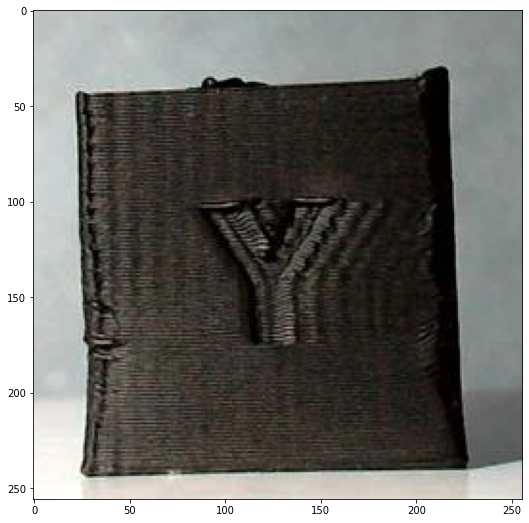

In [22]:
img = main_img[194:450,272:528,:]
print(img.shape)
plt.figure(figsize=(16,9))
plt.imshow(img)

(256, 256, 3)


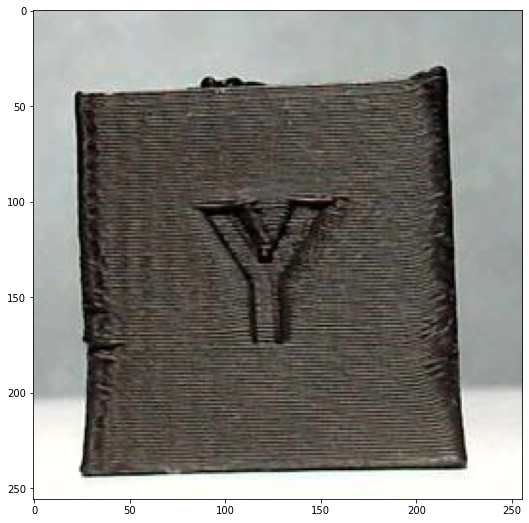

In [7]:
ref_main_img = cv2.imread('./wydruk_3d/b67ff026-dcba-4d53-95e1-60c04ecd8d53.jpg')
ref_img = ref_main_img[194:450,272:528,:]
print(ref_img.shape)
plt.figure(figsize=(16,9))
plt.imshow(ref_img)

# HOG

In [ ]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

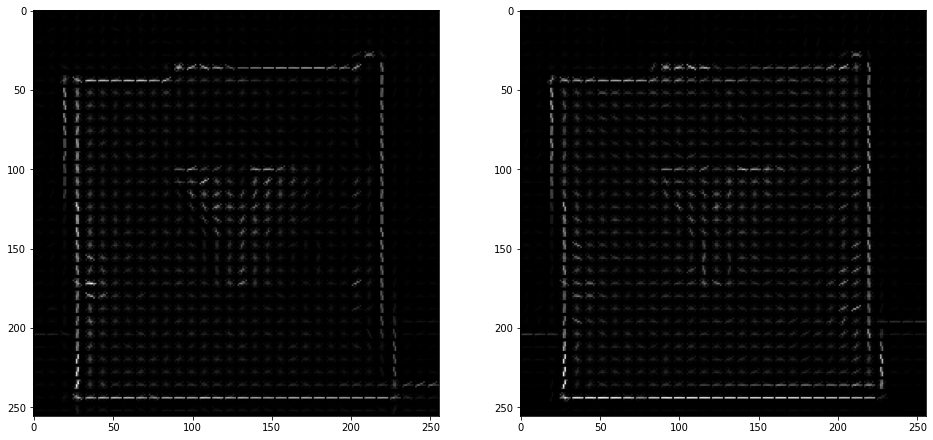

In [ ]:
fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
fd, ref_hog_image = hog(ref_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.figure(figsize=(16,9))
plt.subplot(1, 2, 1)
plt.imshow(hog_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(ref_hog_image, cmap='gray')

# PSNR
Dla każdego zestawu pixeli (zestaw składa się z macierzy 8x8), liczone są wzkaźniki PSNR dla wertykalnych i horyzontalnych pixeli w sąsiedztwie.

In [8]:
def getPSNR(I1, I2):
  s1 = np.abs(I1-I2)
  s1 = np.float32(s1)
  s1 = s1**2
  sse = np.sum(s1)
  if(sse <= 1e-10):
    return 0
  else:
    mse = sse / (I1.shape[0]*I1.shape[1]*I1.shape[2])
    psnr = 10*np.log10((255*255)/mse)
    return psnr

In [42]:
x = int(img.shape[0])
y = int(img.shape[1])

In [43]:
img_margine = np.zeros((x+16,y+16,3),dtype=int)

In [44]:
img_margine[8:x+8,8:y+8,:] = img

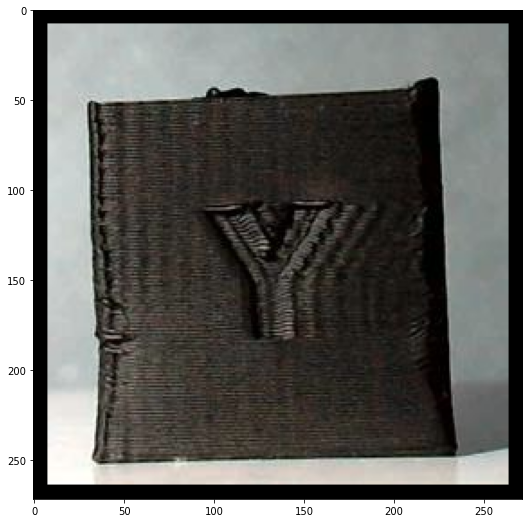

In [46]:
plt.figure(figsize=(16,9))
plt.imshow(img_margine)

In [58]:
img_margine.shape

(272, 272, 3)

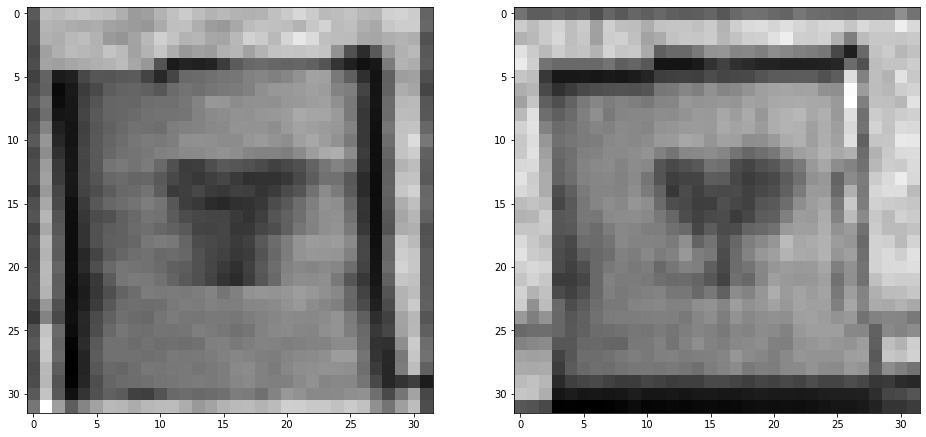

In [64]:
psnr_array_v = np.zeros((int(x/8),int(y/8)))
psnr_array_h = np.zeros((int(x/8),int(y/8)))
for i in range(int(x/8)):
  for j in range(int(y/8)):
    temp_x = i*8+8
    temp_y = j*8+8
    main_v_h = img_margine[temp_x:temp_x+8, temp_y:temp_y+8,:]

    # vertical
    v_up = img_margine[temp_x:temp_x+8, temp_y-8:temp_y,:]
    v_down = img_margine[temp_x:temp_x+8, temp_y+8:temp_y+16,:]
    temp_psnr_up = getPSNR(main_v_h, v_up)
    temp_psnr_down = getPSNR(main_v_h, v_down)
    temp_psnr = (temp_psnr_up+temp_psnr_down)/2
    psnr_array_v[i,j] = temp_psnr

    # horizontal
    h_left = img_margine[temp_x-8:temp_x, temp_y:temp_y+8,:]
    h_right = img_margine[temp_x+8:temp_x+16, temp_y:temp_y+8,:]
    temp_psnr_left = getPSNR(main_v_h, h_left)
    temp_psnr_right = getPSNR(main_v_h, h_right)
    temp_psnr = (temp_psnr_left+temp_psnr_right)/2
    psnr_array_h[i,j] = temp_psnr

plt.figure(figsize=(16,9))
plt.subplot(1, 2, 1)
plt.imshow(psnr_array_v, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(psnr_array_h, cmap='gray')

# SSIM

In [ ]:
def getMSSIM(I1, I2):
  C1 = 6.5025
  C2 = 58.5225
  I1 = np.float32(I1)
  I2 = np.float32(I2)

  I2_2 = I2**2
  I1_2 = I1**2
  I1_I2 = I1*I2

  mu1 = cv2.GaussianBlur(I1, (11,11),1.5)
  mu2 = cv2.GaussianBlur(I2, (11,11),1.5)

  mu1_2 = mu1**2
  mu2_2 = mu2**2
  mu1_mu2 = mu1*mu2

  sigma1_2 = cv2.GaussianBlur(I1_2, (11,11), 1.5)
  sigma1_2 = sigma1_2 - mu1_2
  sigma2_2 = cv2.GaussianBlur(I2_2, (11,11), 1.5)
  sigma2_2 = sigma2_2 - mu2_2
  sigma12 = cv2.GaussianBlur(I1_I2, (11,11), 1.5)
  sigma12 = sigma12 - mu1_mu2

  t1 = 2 * mu1_mu2 + C1
  t2 = 2 * sigma12 + C2
  t3 = t1*t2

  t1 = mu1_2 + mu2_2 + C1
  t2 = sigma1_2 + sigma2_2 + C2
  t1 = t1*t2

  ssim_map = cv2.divide(t2, t1)
  return cv2.mean(ssim_map)

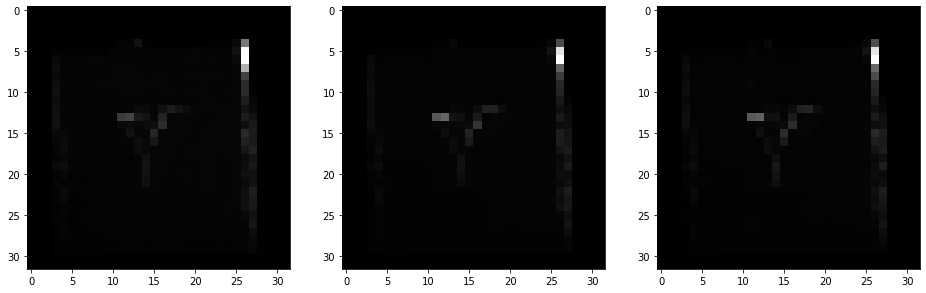

In [ ]:
mssim_b_array = np.zeros((x,y))
mssim_g_array = np.zeros((x,y))
mssim_r_array = np.zeros((x,y))

for i in range(x):
  for j in range(y):
    temp_x = i*8
    temp_y = j*8
    temp_psnr = getMSSIM(ref_img[temp_x:(temp_x+8),temp_y:(temp_y+8),:], img[temp_x:(temp_x+8),temp_y:(temp_y+8),:])
    mssim_b_array[i,j] = temp_psnr[0]
    mssim_g_array[i,j] = temp_psnr[1]
    mssim_r_array[i,j] = temp_psnr[2]

plt.figure(figsize=(16,9))
plt.subplot(1, 3, 1)
plt.imshow(mssim_b_array, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(mssim_g_array, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(mssim_r_array, cmap='gray')

# GLCM

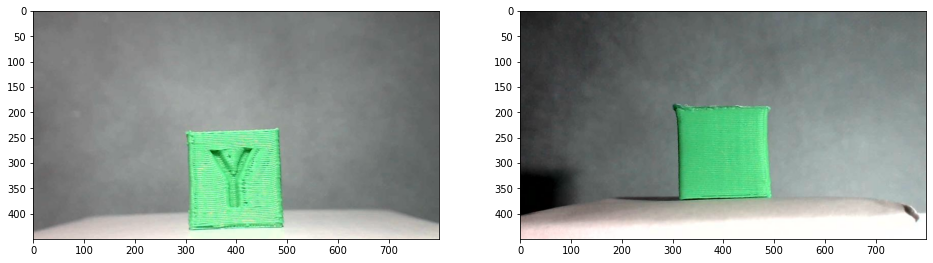

In [ ]:
bad_main_img = cv2.imread('./wydruk_3d/1a4e1cf7-8021-4963-b67a-da7ba93b2a78.jpg')
good_main_img = cv2.imread('./wydruk_3d/1cda8713-2430-4f03-ae05-6ddafc9fb09a.jpg')

plt.figure(figsize=(16,9))
plt.subplot(1, 2, 1)
plt.imshow(bad_main_img)
plt.subplot(1, 2, 2)
plt.imshow(good_main_img)

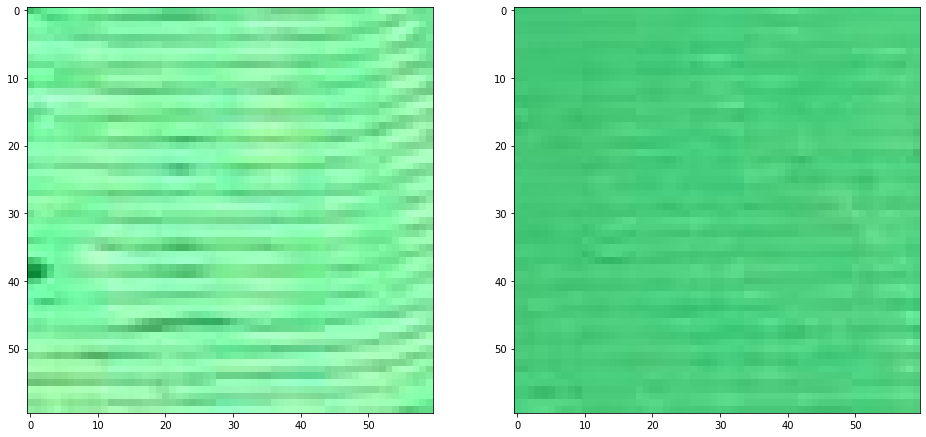

In [ ]:
bad_peace = bad_main_img[340:400,420:480]
good_peace = good_main_img[250:310,350:410]

plt.figure(figsize=(16,9))
plt.subplot(1, 2, 1)
plt.imshow(bad_peace)
plt.subplot(1, 2, 2)
plt.imshow(good_peace)

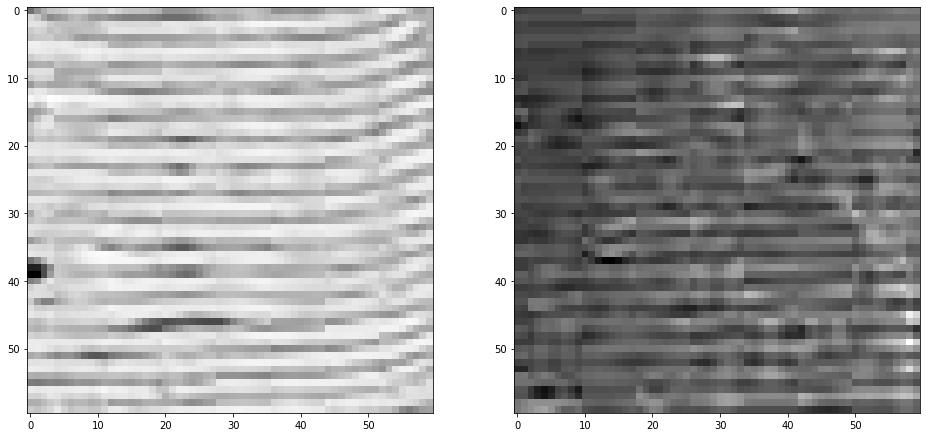

In [ ]:
bad_gray = cv2.cvtColor(bad_peace, cv2.COLOR_BGR2GRAY)
good_gray = cv2.cvtColor(good_peace, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(16,9))
plt.subplot(1, 2, 1)
plt.imshow(bad_gray, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(good_gray, cmap='gray')

In [ ]:
def glcmMatrix(img, offset, luminance_levels):
  M, N = img.shape
  P = M - offset[0]
  Q = N - offset[1]
  C = np.zeros(luminance_levels)
  for i in range(C.shape[0]):
    for j in range(C.shape[0]):
      for p in range(P):
        for q in range(Q):
          if img[p,q] == i and img[p+offset[0], q+offset[1]] == j:
            C[i,j]+=1
  return C

In [ ]:
def equationCalculate(C):
  u = 0 # u
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      u += i*C[i,j]
  q2 = 0 # q^2
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      q2 += C[i,j]*(i-u)**2

  correlation = 0
  contrast = 0
  energy = 0
  homogeneity = 0
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      correlation += C[i,j]*(i-u)*(j-u)/q2
      contrast += C[i,j]*(i-j)**2
      energy += C[i,j]**2
      homogeneity += C[i,j]/(1+(i-j)**2)
  return correlation, contrast, energy, homogeneity

In [ ]:
gray = bad_gray - bad_gray.min()
offset_range = 20

bad_correlation = []
bad_contrast = []
bad_energy = []
bad_homogeneity = []

for i in range(offset_range):
  C_n = glcmMatrix(gray, (i,0), (138,138))
  C_s = C_n + C_n.T
  C = C_s/C_s.sum()
  temp_cor, temp_cont, temp_ener, temp_homo = equationCalculate(C)
  bad_correlation.append(temp_cor)
  bad_contrast.append(temp_cont)
  bad_energy.append(temp_ener)
  bad_homogeneity.append(temp_homo)

In [ ]:
gray = good_gray - good_gray.min()
offset_range = 20

good_correlation = []
good_contrast = []
good_energy = []
good_homogeneity = []

for i in range(offset_range):
  C_n = glcmMatrix(gray, (i,0), (59,59))
  C_s = C_n + C_n.T
  C = C_s/C_s.sum()
  temp_cor, temp_cont, temp_ener, temp_homo = equationCalculate(C)
  good_correlation.append(temp_cor)
  good_contrast.append(temp_cont)
  good_energy.append(temp_ener)
  good_homogeneity.append(temp_homo)

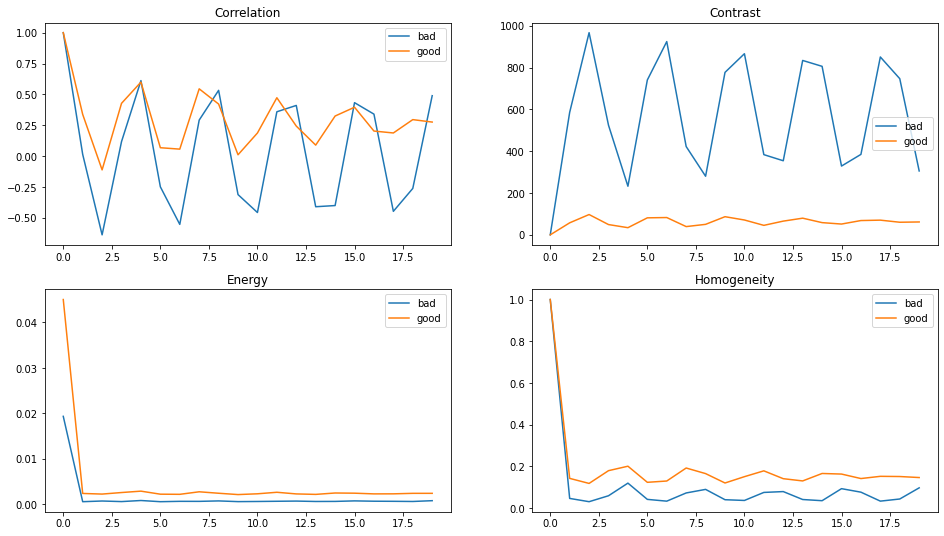

In [ ]:
plt.figure(figsize=(16,9))
plt.subplot(2, 2, 1)
plt.plot(bad_correlation)
plt.plot(good_correlation)
plt.title("Correlation")
plt.legend(['bad', 'good'])
plt.subplot(2, 2, 2)
plt.plot(bad_contrast)
plt.plot(good_contrast)
plt.title("Contrast")
plt.legend(['bad', 'good'])
plt.subplot(2, 2, 3)
plt.plot(bad_energy)
plt.plot(good_energy)
plt.title("Energy")
plt.legend(['bad', 'good'])
plt.subplot(2, 2, 4)
plt.plot(bad_homogeneity)
plt.plot(good_homogeneity)
plt.title("Homogeneity")
plt.legend(['bad', 'good'])